# Assignment 3





import necessary libaries and extensions 

In [1]:
import pandas as pd 
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import openmeteo_requests
import requests_cache
from retry_requests import retry
import scipy

## Retrieveing data

Creating a pd dataframe consiting of the five cities, Oslo, Kristiansand, Trondheim, Tromsø and Bergen, 
icluding their longitude an lattitud and energy price area


Retriving data historical weather data from Bergen 2019 with open meteo API. 
- temperature 2m
- precipitation
- wind speed 10 m 
- wind gusts 10 m 
- wind direction 10 m


In [2]:
#Saving price area codes, city names, longitude and latitude in a Pandas data frame.

data = [
    ['NO1', 'Oslo', 10.7522, 59.9139],
    ['NO2', 'Kristiansand', 8.0000, 58.1467],
    ['NO3', 'Trondheim', 10.3951, 63.4305],
    ['NO4', 'Tromsø', 18.9553, 69.6496],
    ['NO5', 'Bergen', 5.3221, 60.39299],
]

df = pd.DataFrame(data, columns=['PriceArea', 'City', 'Longitude', 'Latitude'])
print(df)

  PriceArea          City  Longitude  Latitude
0       NO1          Oslo    10.7522  59.91390
1       NO2  Kristiansand     8.0000  58.14670
2       NO3     Trondheim    10.3951  63.43050
3       NO4        Tromsø    18.9553  69.64960
4       NO5        Bergen     5.3221  60.39299


In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)



In [ ]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 60.393,
	"longitude": 5.3242,
	"start_date": "2019-01-01",
	"end_date": "2019-12-31",
	"hourly": ["temperature_2m", "precipitation", "wind_speed_10m", "wind_gusts_10m", "wind_direction_10m"],
}
responses = openmeteo.weather_api(url, params=params)


if len(responses) > 0:
    print('Success')
else: 
    print('No data fetched ')

Success


In [5]:
# Process Bergen weather data 
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(2).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)

Coordinates: 60.421791076660156°N 5.2941179275512695°E
Elevation: 17.0 m asl
Timezone difference to GMT+0: 0s

Hourly data
                           date  temperature_2m  precipitation  wind_speed_10m  \
0    2019-01-01 00:00:00+00:00           5.772            0.2       41.036842   
1    2019-01-01 01:00:00+00:00           6.072            0.7       42.033756   
2    2019-01-01 02:00:00+00:00           6.322            0.5       40.913490   
3    2019-01-01 03:00:00+00:00           5.822            1.1       41.238468   
4    2019-01-01 04:00:00+00:00           5.722            0.7       44.140755   
...                        ...             ...            ...             ...   
8755 2019-12-31 19:00:00+00:00           4.972            0.7       11.525623   
8756 2019-12-31 20:00:00+00:00           5.872            0.7       12.984975   
8757 2019-12-31 21:00:00+00:00           6.372            0.3       14.618837   
8758 2019-12-31 22:00:00+00:00           6.122            0.1     

In [6]:
hourly_dataframe.describe()

,temperature_2m,precipitation,wind_speed_10m,wind_gusts_10m,wind_direction_10m
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,7.828758,0.246450,10.685799,29.520823,186.511353
std,5.999574,0.583147,6.047772,16.090151,96.201706
min,-12.878000,0.000000,0.000000,2.520000,1.169115
25%,3.072000,0.000000,6.120000,16.919998,116.564987
50%,7.222000,0.000000,9.531505,26.639999,164.836456
75%,12.084500,0.200000,14.332340,39.599998,279.462250
max,31.722000,9.500000,46.675217,131.040009,360.000000


In [7]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date                8760 non-null   datetime64[ns, UTC]
 1   temperature_2m      8760 non-null   float32            
 2   precipitation       8760 non-null   float32            
 3   wind_speed_10m      8760 non-null   float32            
 4   wind_gusts_10m      8760 non-null   float32            
 5   wind_direction_10m  8760 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 239.7 KB


In [8]:
# checking for summer time

print(f"SUMMER: {hourly_dataframe.iloc[int(len(hourly_dataframe)/2)].date}")
print("-"*33)
print(f"WINTER: {hourly_dataframe.iloc[0].date}")


SUMMER: 2019-07-02 12:00:00+00:00
---------------------------------
WINTER: 2019-01-01 00:00:00+00:00


In [9]:
date = hourly_dataframe['date'].to_numpy()
hourly_temperature_2m

array([5.772, 6.072, 6.322, ..., 6.372, 6.122, 5.972],
      shape=(8760,), dtype=float32)

# Bergen weather data 

### Temperature 
Starting with a plot of the temperature as a function of time. 


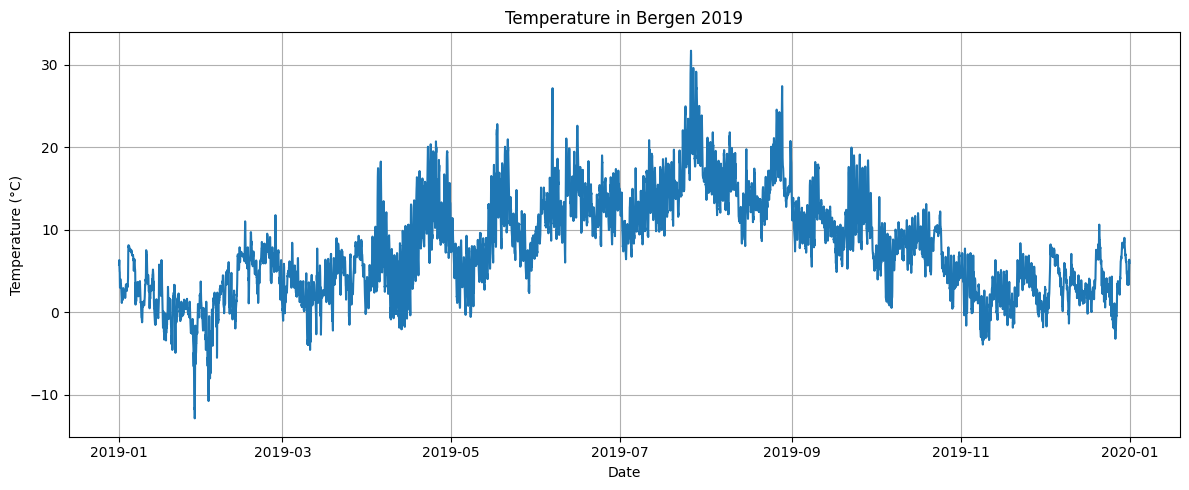

In [ ]:
# Plotting temperature as a function of time 

plt.figure(figsize=(12, 5))
plt.plot(date, hourly_temperature_2m, label="Temperature (°C)")

plt.title("Temperature in Bergen 2019")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.tight_layout()
plt.grid(True)


Perform a high-pass filtering of the temperature using Direct Cosine Transfer to create seasonally adjusted temperature variations (SATV)

Creating a high pass filter using Direct Cosine Transfer 
 - creates an array where the lower indicies are the slow variating - seasonal variations 
 - Cut off at 50: removes the 50 lowest frequencies - seasonal variations
 - reconstruction the temperaturedata without sesonal variations - SATV



In [55]:
from scipy.fft import dct, idct

# Calculating direct cosinus transformation
temps_dct = dct(hourly_temperature_2m, norm='ortho')

# High pass filtering 
cutoff = 50   # lower values will remove more season
temps_dct_hp = temps_dct.copy()
temps_dct_hp[:cutoff] = 0  # setting the values lower than cut off to 0 

# reconstructing temperature data 
temps_satv = idct(temps_dct_hp, norm='ortho')




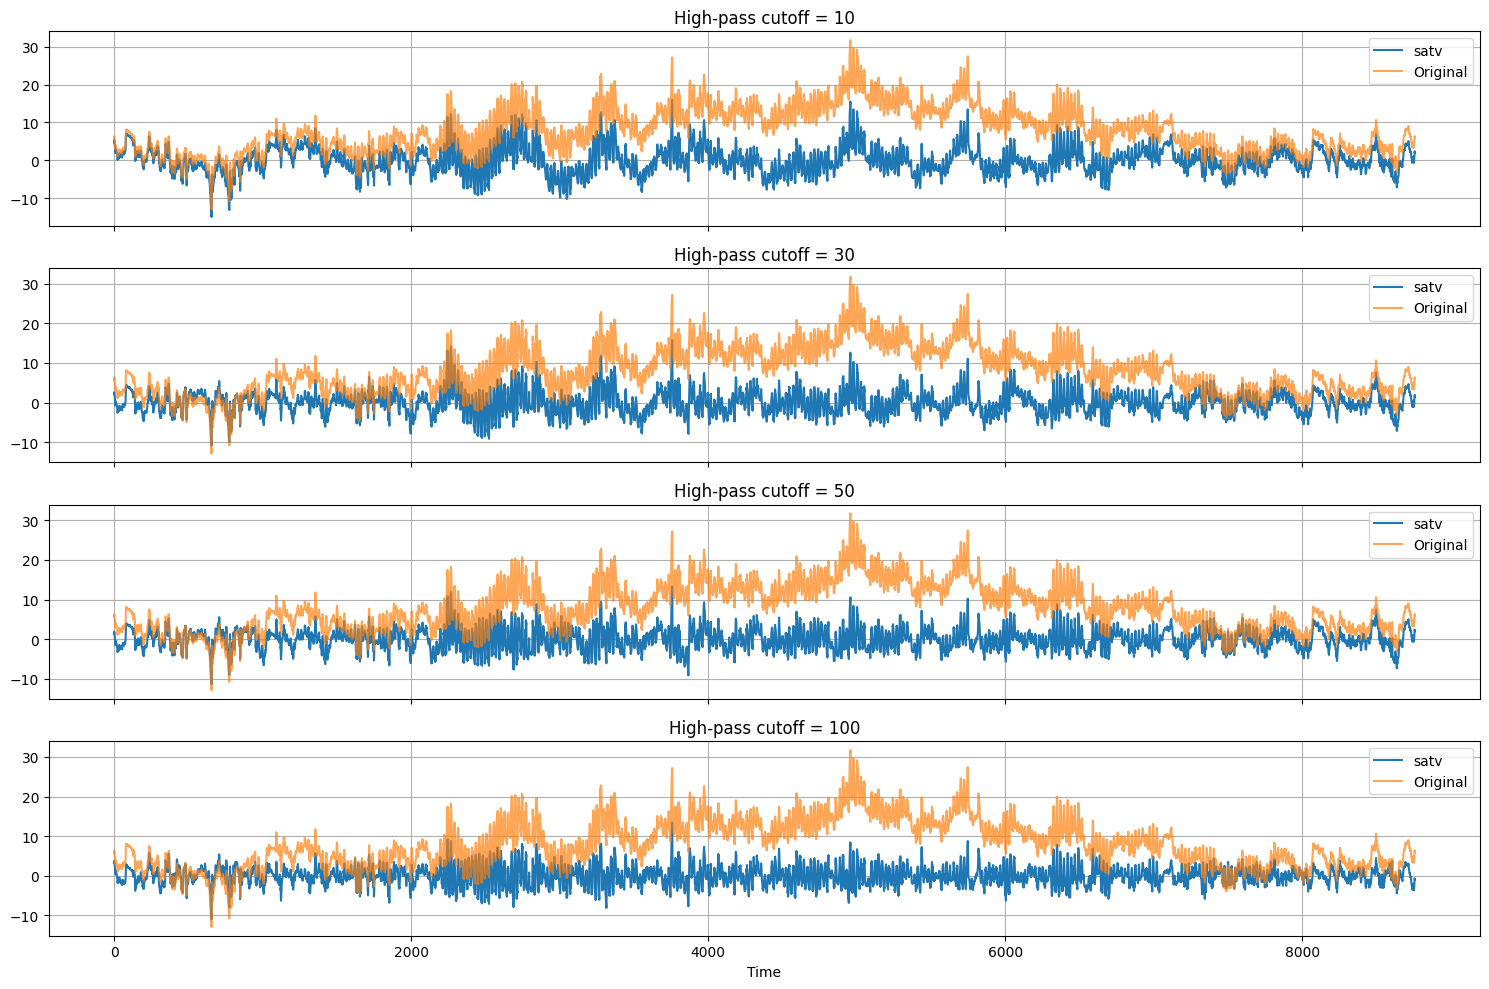

In [ ]:
# Observing how different cutoffs will affect the data 
cutoffs = [10, 30, 50, 100]

fig, axes = plt.subplots(len(cutoffs), 1, figsize=(15, 10), sharex=True)

for ax, c in zip(axes, cutoffs):
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:c] = 0
    temps_satv = idct(temps_dct_hp, norm='ortho')
    
    ax.plot(temps_satv, label = 'SATV')
    ax.plot(hourly_temperature_2m, label='Original', alpha = 0.7)
    ax.set_title(f'High-pass cutoff = {c}')
    ax.grid(True)
    ax.legend()  # Legg til legend for hver subplot

axes[-1].set_xlabel('Time')
plt.tight_layout()
plt.show()

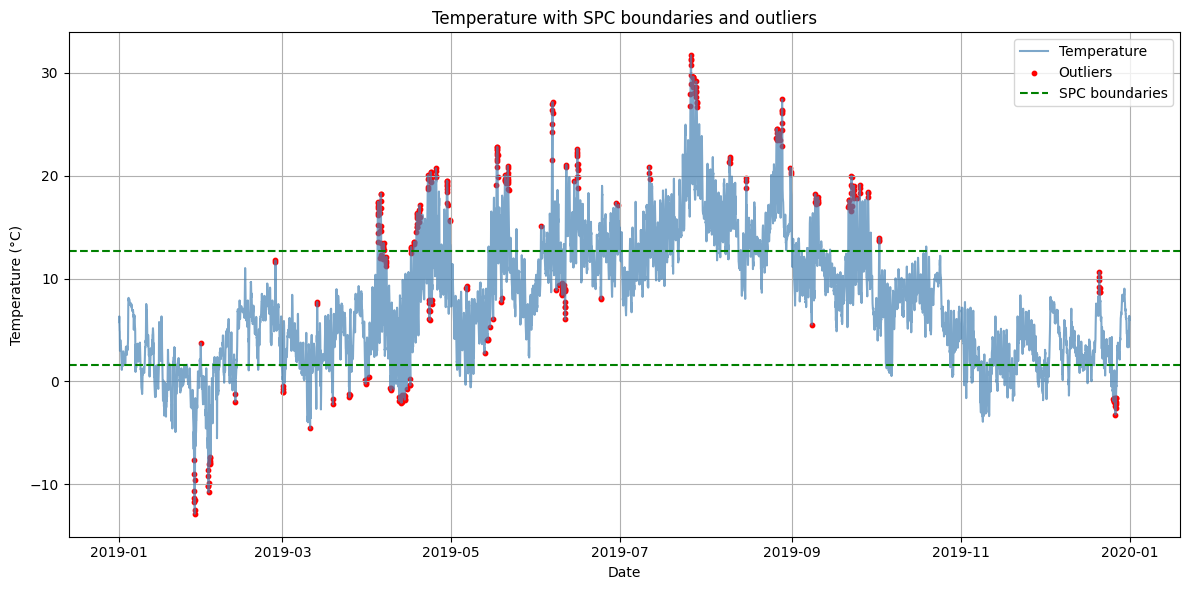

Total points       : 8760
Outlier count      : 348
Outlier percentage : 3.97%
MAD                : 1.86
Upper limit        : 5.50
Lower limit        : -5.65


In [ ]:
def plot_temperature_with_spc(df, temp_col="temperature_2m", date_col="date", 
                              cutoff=50, n_std=3):
    """
    Plot temperature over time, add SPC boundaries based on SATV (DCT high-pass filtered signal),
    and highlight outliers.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing date and temperature columns.
        temp_col (str): Name of the temperature column.
        date_col (str): Name of the datetime column.
        cutoff (int): Number of low DCT frequencies to remove (high-pass filter).
        n_std (float): Number of MAD deviations defining SPC boundaries.
    
    Returns:
        outlier_summary (pd.DataFrame): DataFrame with timestamps and temperatures of outliers.
    """

    # collecting and converting data
    temps = df[temp_col].to_numpy()
    dates = pd.to_datetime(df[date_col]) # converting to pd daytime

    # DCT and high-pass filter
    temps_dct = dct(temps, norm='ortho')
    temps_dct_hp = temps_dct.copy()
    temps_dct_hp[:cutoff] = 0  
    temps_satv = idct(temps_dct_hp, norm='ortho')

    # Robust statistics 
    median_satv = np.median(temps_satv)
    mad_satv = np.median(np.abs(temps_satv - median_satv))
    upper_limit = median_satv + n_std * mad_satv # calculating upper boundary
    lower_limit = median_satv - n_std * mad_satv # calculating lower boundary

    # Finding data outside the boundaries
    outliers = (temps_satv > upper_limit) | (temps_satv < lower_limit)
    outlier_df = df.loc[outliers, [date_col, temp_col]].copy()
    outlier_df["SATV_value"] = temps_satv[outliers]

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(dates, temps, label="Temperature", color="steelblue", alpha=0.7)
    plt.scatter(dates[outliers], temps[outliers], color="red", s=10, label="Outliers")

    baseline = np.median(temps)
    plt.axhline(baseline + upper_limit, color="green", linestyle="--", label="SPC boundaries")
    plt.axhline(baseline + lower_limit, color="green", linestyle="--")

    plt.title("Temperature with SPC boundaries and outliers")
    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # summery of statistics
    print(
        f"Total points       : {len(df)}\n"
        f"Outlier count      : {outlier_df.shape[0]}\n"
        f"Outlier percentage : {100 * outlier_df.shape[0] / len(df):.2f}%\n"
        f"MAD                : {mad_satv:.2f}\n"
        f"Upper limit        : {upper_limit:.2f}\n"
        f"Lower limit        : {lower_limit:.2f}"
    )
    return outlier_df


outliers = plot_temperature_with_spc(hourly_dataframe, cutoff=50, n_std=3)



## Precipitation

- plotting precipitation as a function of time 
- anomalies: local outlier factor 


Text(0, 0.5, 'Precipitation (mm)')

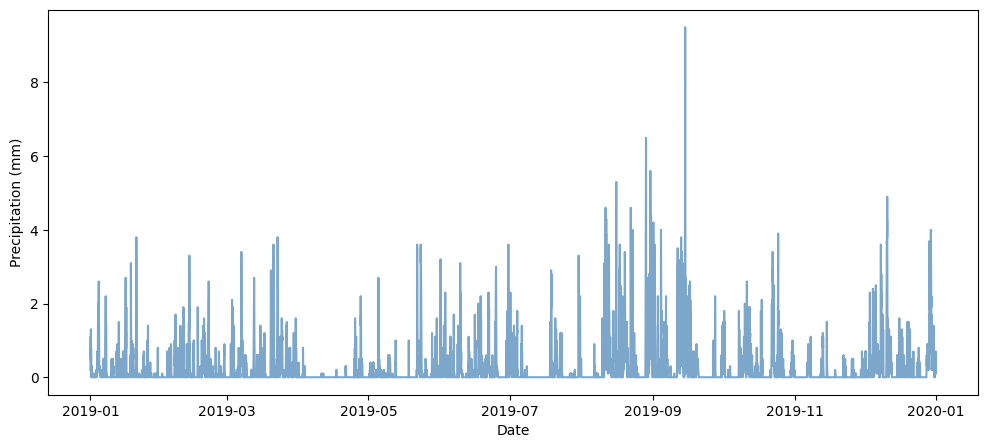

In [64]:
plt.figure(figsize=(12,5))
plt.plot(date, hourly_precipitation, label="Precipitation", color="steelblue", alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')

ANOMALIES 

c:\Users\heito\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


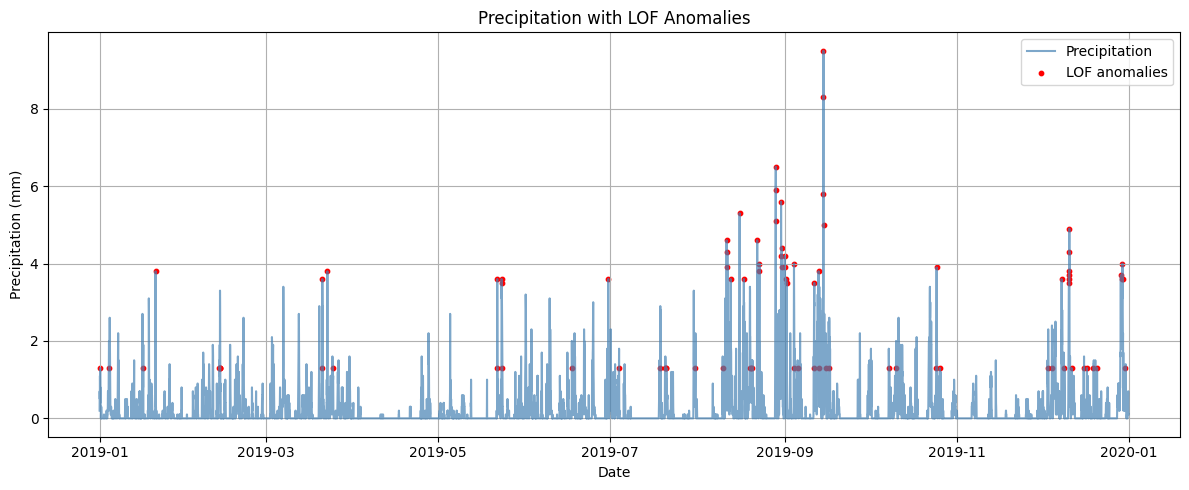


Summary:
Total points: 8760.00
Outlier count: 87.00
Outlier percentage: 0.99


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def plot_precipitation_with_lof(df, precip_col="precipitation", date_col="date",
                                n_neighbors=50, contamination=0.01):
    """
    Plot precipitation over time and indicate anomalies using Local Outlier Factor.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing precipitation and date columns
        precip_col (str): Name of precipitation column
        date_col (str): Name of datetime column
        n_neighbors (int): Number of neighbors for LOF (default to 50) 
        contamination (float): Expected proportion of outliers (default 0.01 = 1%)
    
    Returns:
        outlier_df (pd.DataFrame): DataFrame with timestamps and precipitation of detected outliers
    """
    
    # Collecting and converting data
    dates = pd.to_datetime(df[date_col])
    X = df[precip_col].values.reshape(-1, 1)
    
    # Anomaly detection using Local outlier factor (LOF)
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = lof.fit_predict(X)  # -1 = outlier, 1 = inlier
    anomalies = y_pred == -1
    
    # Creating a DataFrame with only the detected outlier rows (date and precipitation columns)
    outlier_df = df.loc[anomalies, [date_col, precip_col]].copy()
    
    # --- 3. Plot ---
    plt.figure(figsize=(12,5))
    plt.plot(dates, df[precip_col], color="steelblue", alpha=0.7, label="Precipitation")
    plt.scatter(outlier_df[date_col], outlier_df[precip_col], color="red", s=10, label="LOF anomalies")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.title("Precipitation with LOF Anomalies")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- 4. Summary ---
    summary = {
        "Total points": len(df),
        "Outlier count": outlier_df.shape[0],
        "Outlier percentage": 100 * outlier_df.shape[0] / len(df)
    }
    print("\nSummary:")
    for k, v in summary.items():
        print(f"{k}: {v:.2f}" if isinstance(v, (int,float)) else f"{k}: {v}")
    
    return outlier_df

# --- 5. Test function ---
outliers = plot_precipitation_with_lof(hourly_dataframe, precip_col="precipitation", date_col="date")



c:\Users\heito\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


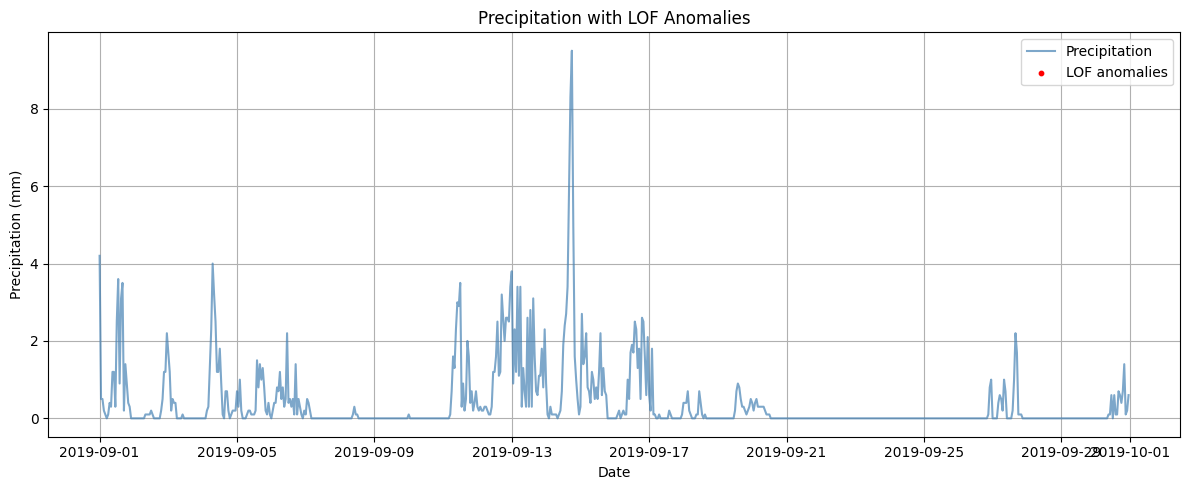


Summary:
Total points: 720.00
Outlier count: 0.00
Outlier percentage: 0.00


In [20]:
sept_data = hourly_dataframe[hourly_dataframe['date'].dt.month == 9].copy()
outliers = plot_precipitation_with_lof(sept_data, precip_col="precipitation", date_col="date")

c:\Users\heito\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


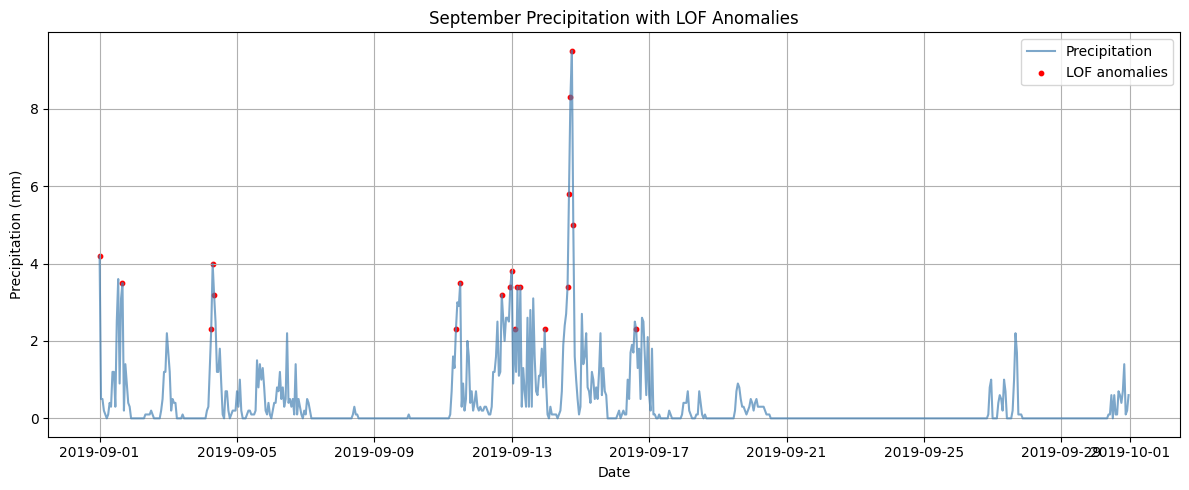


Summary for September:
Total points in September: 720.00
Outlier count: 20.00
Outlier percentage: 2.78


In [21]:
def plot_precipitation_with_lof_september(df, precip_col="precipitation", date_col="date",
                                           n_neighbors=50, contamination=0.01):
    """
    Plot precipitation for September and indicate anomalies using LOF.
    LOF is computed on the whole dataset, but only September is plotted.
    """
    # --- 1. Prepare data for LOF (whole dataset) ---
    dates_all = pd.to_datetime(df[date_col])
    X = df[precip_col].values.reshape(-1, 1)
    
    # --- 2. LOF anomaly detection ---
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = lof.fit_predict(X)
    anomalies_all = y_pred == -1
    
    outlier_df = df.loc[anomalies_all, [date_col, precip_col]].copy()
    
    # --- 3. Filter for September for plotting ---
    sept_mask = df[date_col].dt.month == 9
    dates_sept = df.loc[sept_mask, date_col]
    precip_sept = df.loc[sept_mask, precip_col]
    anomalies_sept = anomalies_all[sept_mask.values]  # behold røde prikker på riktig plass
    
    # --- 4. Plot ---
    plt.figure(figsize=(12,5))
    plt.plot(dates_sept, precip_sept, color="steelblue", alpha=0.7, label="Precipitation")
    plt.scatter(dates_sept[anomalies_sept], precip_sept[anomalies_sept],
                color="red", s=10, label="LOF anomalies")
    plt.xlabel("Date")
    plt.ylabel("Precipitation (mm)")
    plt.title("September Precipitation with LOF Anomalies")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- 5. Summary for September ---
    outlier_sept_df = outlier_df[outlier_df[date_col].dt.month == 9]
    summary = {
        "Total points in September": len(dates_sept),
        "Outlier count": len(outlier_sept_df),
        "Outlier percentage": 100 * len(outlier_sept_df) / len(dates_sept)
    }
    print("\nSummary for September:")
    for k, v in summary.items():
        print(f"{k}: {v:.2f}" if isinstance(v, (int,float)) else f"{k}: {v}")
    
    return outlier_sept_df

# --- 6. Test function ---
outliers_sept = plot_precipitation_with_lof_september(hourly_dataframe, 
                                                      precip_col="precipitation", 
                                                      date_col="date",
                                                      n_neighbors=20,  # pass på at dette er < antall september-punkter
                                                      contamination=0.05)  # høyere for små datasett



c:\Users\heito\miniconda3\envs\D2D_env\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


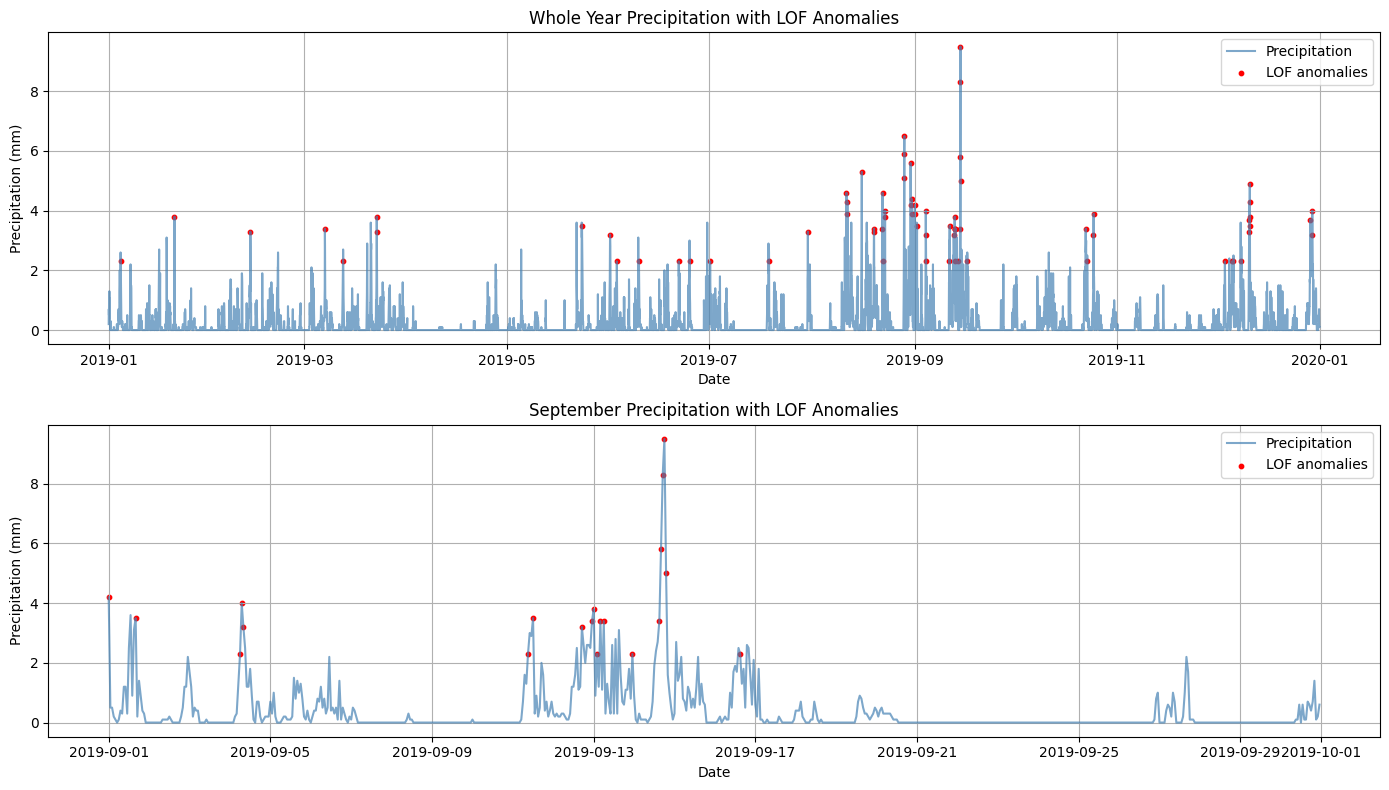


Summary:
Total points (year): 8760
Outliers (year): 72
Total points (September): 720
Outliers (September): 20


In [22]:


def plot_precipitation_year_vs_sept(df, precip_col="precipitation", date_col="date",
                                    n_neighbors=50, contamination=0.01):
    """
    Plot precipitation for the whole year and September side by side, with LOF anomalies.
    LOF is computed on the whole dataset.
    """
    # --- Prepare data ---
    df[date_col] = pd.to_datetime(df[date_col])
    dates_all = df[date_col]
    X = df[precip_col].values.reshape(-1, 1)
    
    # --- LOF on whole dataset ---
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    y_pred = lof.fit_predict(X)
    anomalies_all = y_pred == -1
    
    # --- Anomalies DataFrame ---
    outlier_df = df.loc[anomalies_all, [date_col, precip_col]].copy()
    
    # --- Masks ---
    sept_mask = df[date_col].dt.month == 9
    dates_sept = df.loc[sept_mask, date_col]
    precip_sept = df.loc[sept_mask, precip_col]
    anomalies_sept = anomalies_all[sept_mask.values]
    
    # --- Plotting ---
    fig, axs = plt.subplots(2,1, figsize=(14,8), sharey=True)
    
    # Whole year
    axs[0].plot(dates_all, df[precip_col], color='steelblue', alpha=0.7, label='Precipitation')
    axs[0].scatter(dates_all[anomalies_all], df[precip_col][anomalies_all], color='red', s=10, label='LOF anomalies')
    axs[0].set_title('Whole Year Precipitation with LOF Anomalies')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Precipitation (mm)')
    axs[0].legend()
    axs[0].grid(True)
    
    # September
    axs[1].plot(dates_sept, precip_sept, color='steelblue', alpha=0.7, label='Precipitation')
    axs[1].scatter(dates_sept[anomalies_sept], precip_sept[anomalies_sept], color='red', s=10, label='LOF anomalies')
    axs[1].set_title('September Precipitation with LOF Anomalies')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Precipitation (mm)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # --- Summary ---
    outlier_sept_df = outlier_df[outlier_df[date_col].dt.month == 9]
    summary = {
        "Total points (year)": len(df),
        "Outliers (year)": len(outlier_df),
        "Total points (September)": len(dates_sept),
        "Outliers (September)": len(outlier_sept_df)
    }
    
    print("\nSummary:")
    for k, v in summary.items():
        print(f"{k}: {v}")
    
    return outlier_df, outlier_sept_df

# --- Test function ---
outliers_year, outliers_sept = plot_precipitation_year_vs_sept(
    hourly_dataframe, precip_col="precipitation", date_col="date",
    n_neighbors=20, contamination=0.05
)


## ELHUB


In [23]:
df = pd.read_csv("elhub_production.csv")

In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   area             215353 non-null  object 
 1   productionGroup  215353 non-null  object 
 2   startTime        215353 non-null  object 
 3   quantityKwh      215353 non-null  float64
dtypes: float64(1), object(3)
memory usage: 6.6+ MB


In [25]:
df['startTime'] = pd.to_datetime(df['startTime'], utc = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215353 entries, 0 to 215352
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   area             215353 non-null  object             
 1   productionGroup  215353 non-null  object             
 2   startTime        215353 non-null  datetime64[ns, UTC]
 3   quantityKwh      215353 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 6.6+ MB


In [26]:
df.head()

,area,productionGroup,startTime,quantityKwh
0,NO1,hydro,2020-12-31 23:00:00+00:00,2507716.8
1,NO1,hydro,2021-01-01 00:00:00+00:00,2494728.0
2,NO1,hydro,2021-01-01 01:00:00+00:00,2486777.5
3,NO1,hydro,2021-01-01 02:00:00+00:00,2461176.0
4,NO1,hydro,2021-01-01 03:00:00+00:00,2466969.2


### Seasonal-Trend decomposition using LOESS (STL)

    Perform LOESS on the production data from elbub (downloaded in part 1 of the project) and plot its decomposition.
    Let the electricity price area, production group, period length, seasonal smoother, trend smoother and robust (true/false) be parameters, and give each of them sensible defaults.
    Wrap this in a function that returns the plot, and test the function.


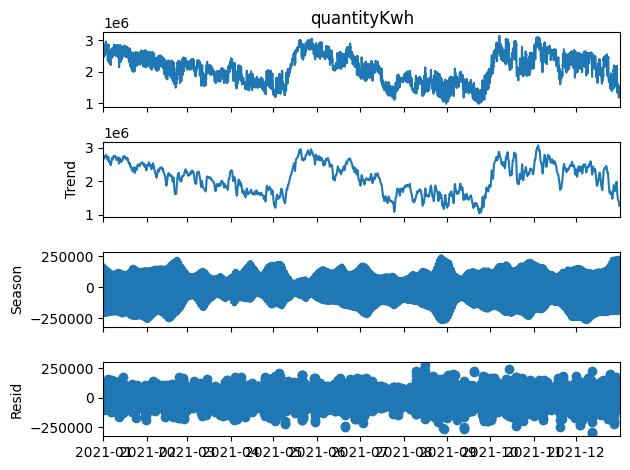

<Figure size 1000x600 with 0 Axes>

In [27]:
from statsmodels.tsa.seasonal import STL

def plot_stl_decomposition(df, area="NO1", productionGroup="hydro", 
                           period=24, seasonal=13, trend=13, robust=False):
    """
    Perform STL decomposition on elhub production data and plot the result.

    Parameters:
        df (pd.DataFrame): DataFrame with columns area, productionGroup, startTime, quantityKwh
        area (str): Price area, e.g., "NO1"
        productionGroup (str): Production group, e.g., "hydro"
        period (int): Seasonal period (e.g., 24 for daily cycle)
        seasonal (int): Seasonal smoother length
        trend (int): Trend smoother length
        robust (bool): Whether to use robust fitting

    Returns:
        stl (STL): STL object with decomposition
    """
    # --- 1. Filter data ---
    df_filtered = df[(df['area'] == area) & (df['productionGroup'] == productionGroup)].copy()
    df_filtered = df_filtered.sort_values('startTime')
    
    # --- 2. Lagre tidsserie ---
    ts = df_filtered.set_index('startTime')['quantityKwh']
    
    # --- 3. STL decomposition ---
    stl = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()
    
    # --- 4. Plot ---
    result.plot()
    plt.figure(figsize=(10, 6))
    plt.suptitle(f"STL decomposition for {productionGroup} in {area}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return result

# --- 5. Test function ---
stl_result = plot_stl_decomposition(df, area="NO1", productionGroup="hydro",
                                     period=24, seasonal=13, trend=25)



### Spectrogram
Create a spectrogram based on the production data from elhub.
Let the electricity price area, production group, window length and window overlap be parameters, and give each of them sensible defaults.
Wrap this in a function that returns the plot, and test the function.


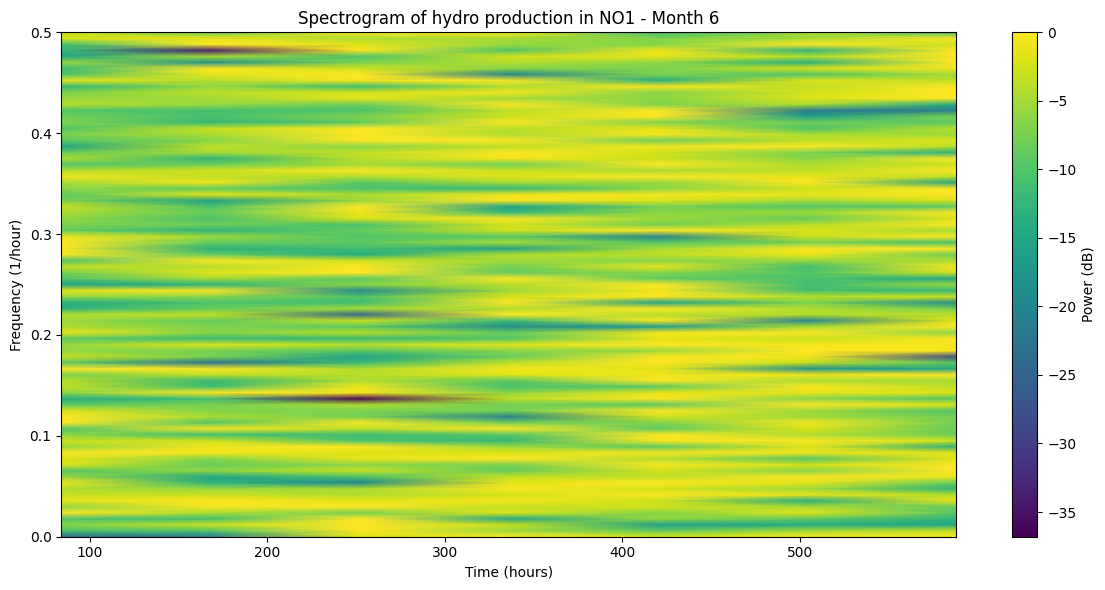

In [28]:

from scipy.signal import spectrogram


def plot_production_spectrogram(df, area="NO1", productionGroup="hydro",
                                window_length=168, window_overlap=84, fs=1,
                                month=None, log_scale=True, normalize=False):
    """
    Create a spectrogram from Elhub production data with better visualization.

    Parameters:
        df (pd.DataFrame): DataFrame with columns area, productionGroup, startTime, quantityKwh
        area (str): Price area, e.g., "NO1"
        productionGroup (str): Production group, e.g., "hydro"
        window_length (int): Window length in number of points for FFT
        window_overlap (int): Overlap between windows
        fs (float): Sampling frequency (per hour = 1)
        month (int or None): If specified, plot only this month (1=Jan,...,12=Dec)
        log_scale (bool): If True, use log10 of power for plotting
        normalize (bool): If True, normalize each frequency to max power
    Returns:
        f, t, Sxx: Frequencies, times, and spectrogram power
    """
    # --- 1. Filter data ---
    df_filtered = df[(df['area'] == area) & (df['productionGroup'] == productionGroup)].copy()
    df_filtered = df_filtered.sort_values('startTime')
    
    if month is not None:
        df_filtered = df_filtered[df_filtered['startTime'].dt.month == month]
    
    ts = df_filtered.set_index('startTime')['quantityKwh'].values
    if len(ts) < window_length:
        raise ValueError("Time series is shorter than window length.")
    
    # --- 2. Spectrogram ---
    f, t, Sxx = spectrogram(ts, fs=fs, nperseg=window_length, noverlap=window_overlap)
    
    if normalize:
        Sxx = Sxx / (Sxx.max(axis=1, keepdims=True) + 1e-12)
    
    if log_scale:
        Sxx_plot = 10 * np.log10(Sxx + 1e-10)
        cbar_label = 'Power (dB)'
    else:
        Sxx_plot = Sxx
        cbar_label = 'Power'
    
    # --- 3. Plot ---
    plt.figure(figsize=(12,6))
    plt.pcolormesh(t, f, Sxx_plot, shading='gouraud')
    plt.ylabel('Frequency (1/hour)')
    plt.xlabel('Time (hours)')
    title = f"Spectrogram of {productionGroup} production in {area}"
    if month is not None:
        title += f" - Month {month}"
    plt.title(title)
    plt.colorbar(label=cbar_label)
    plt.tight_layout()
    plt.show()
    
    return f, t, Sxx
# --- Test the function ---¨

f, t, Sxx = plot_production_spectrogram(df, area="NO1", productionGroup="hydro",
                                        window_length=168, window_overlap=84,
                                        month=6, log_scale=True, normalize=True)